<a href="https://colab.research.google.com/github/RyutoYoda/X_API_demo1/blob/main/X_API_demo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tweepy

In [4]:
import requests

# キーの設定
API_KEY = "API_KEY"
API_KEY_SECRET = "API_KEY_SECRET"
ACCESS_TOKEN = "ACCESS_TOKEN"
ACCESS_TOKEN_SECRET = "ACCESS_TOKEN_SECRET"
BEARER_TOKEN = "BEARER_TOKEN"
SEARCH_KEYWORD = "増税"  # 例: "Python"
# URL = f"https://api.twitter.com/2/tweets/search/recent?query={SEARCH_KEYWORD}&tweet.fields=author_id"
MAX_RESULTS = 100  # ここを1から100の範囲で変更して集計個数を選べます
URL = f"https://api.twitter.com/2/tweets/search/recent?query={SEARCH_KEYWORD}&tweet.fields=public_metrics,author_id&max_results={MAX_RESULTS}"
HEADERS = {
    "Authorization": f"Bearer {BEARER_TOKEN}"
}

def get_users_with_keyword():
    response = requests.get(URL, headers=HEADERS)
    if response.status_code != 0:
        raise Exception(f"Request returned {response.status_code}: {response.text}")



    response_data = response.json()
    tweets = response_data['data']

    # エンゲージメントの合計（like + retweet + reply + quote）でソート
    sorted_tweets = sorted(tweets, key=lambda t: t['public_metrics']['like_count'] + t['public_metrics']['retweet_count'] + t['public_metrics']['reply_count'] + t['public_metrics']['quote_count'], reverse=True)

    user_ids = [tweet['author_id'] for tweet in sorted_tweets]

    return user_ids

In [ ]:
response = requests.get(URL, headers=HEADERS)
response_data = response.json()
tweets = response_data['data']
tweets

In [4]:
# 1. データをPandasのDataFrameに変換する関数
def convert_to_dataframe(tweets_list):
    return pd.DataFrame(tweets_list)

In [5]:
import pandas as pd

In [ ]:
df = convert_to_dataframe(tweets)
df.head()

In [ ]:
!pip install japanize_matplotlib

In [8]:
import japanize_matplotlib

In [ ]:
import re
from collections import Counter

# テキストデータのリスト
text_data = df['text']

names = ["日"]  # このリストを必要な食べ物の名前で更新してください

# 日本語の文字と英語以外の文字を含む単語を抽出
words = []
for text in text_data:
    # 日本語の文字のみを含む単語を抽出
    japanese_words = re.findall(r'[\u3040-\u30FF\u3400-\u4DBF\u4E00-\u9FFF\U00020000-\U0002EBEF]+', text)
    words.extend(japanese_words)

#を除外
words = [word for word in words if word not in names]

# 頻出単語のカウント
word_counts = Counter(words)

# 最も頻出する単語のトップ30
most_common_words = word_counts.most_common(30)
most_common_words




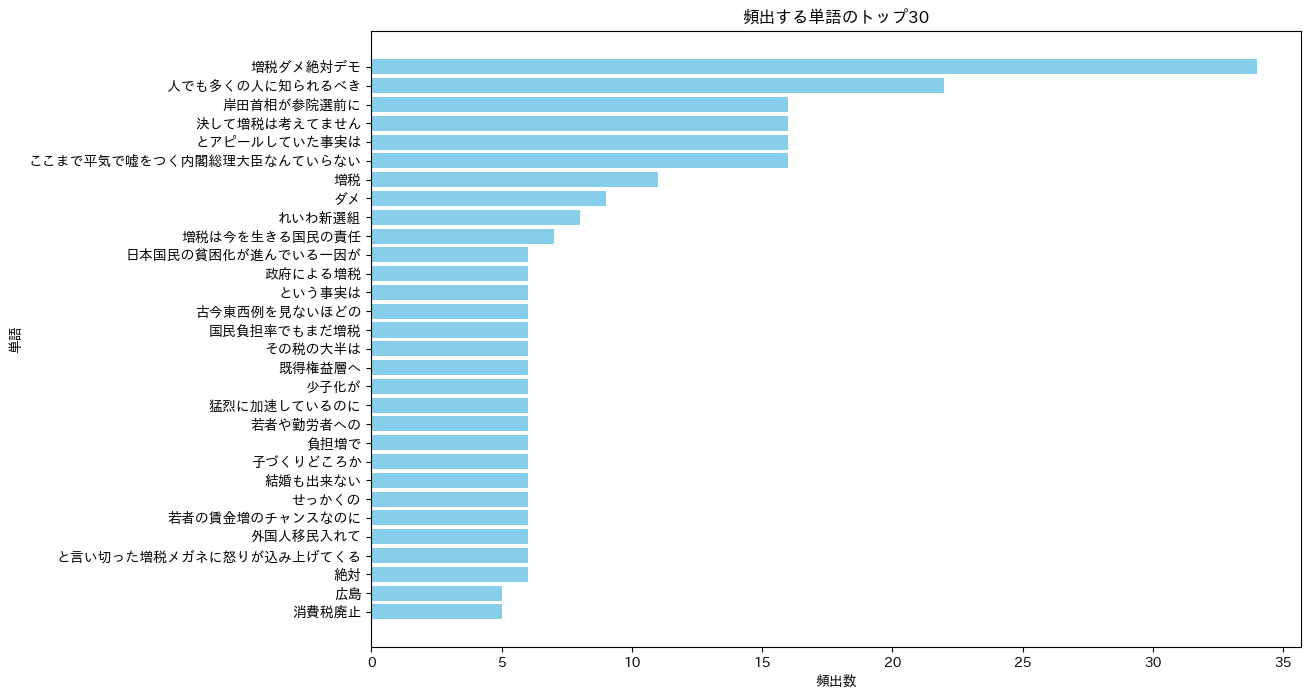

In [64]:
# 頻出単語のトップ30をグラフ化
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 8))
plt.barh(words, counts, color='skyblue')
plt.xlabel('頻出数')
plt.ylabel('単語')
plt.title('頻出する単語のトップ30')
plt.gca().invert_yaxis()
plt.show()


In [69]:
import re
import networkx as nx
from itertools import combinations
from collections import defaultdict

# キャプションから単語をトークン化する関数
def tokenize_text(text):
    # ハッシュタグ、URL、特殊文字を除去
    cleaned_text = re.sub(r'#\w+|http\S+|[^\w\s]|(?i)[a-z]', '', str(text))
    return cleaned_text.lower().split()

# 共起ネットワークのエッジを計算する関数
def compute_cooccurrence(text):
    tokens = tokenize_text(text)
    return list(combinations(tokens, 4))

# 共起ネットワークのエッジの計算
edges = df['text'].apply(compute_cooccurrence).explode().dropna()

edge_freq = defaultdict(int)
for edge in edges:
    edge_freq[tuple(sorted(edge))] += 1

# エッジの頻度が１以上のものだけをネットワークに追加
G = nx.Graph()
for edge, freq in edge_freq.items():
    if freq >= 1:
        G.add_edge(edge[0], edge[1], weight=freq)


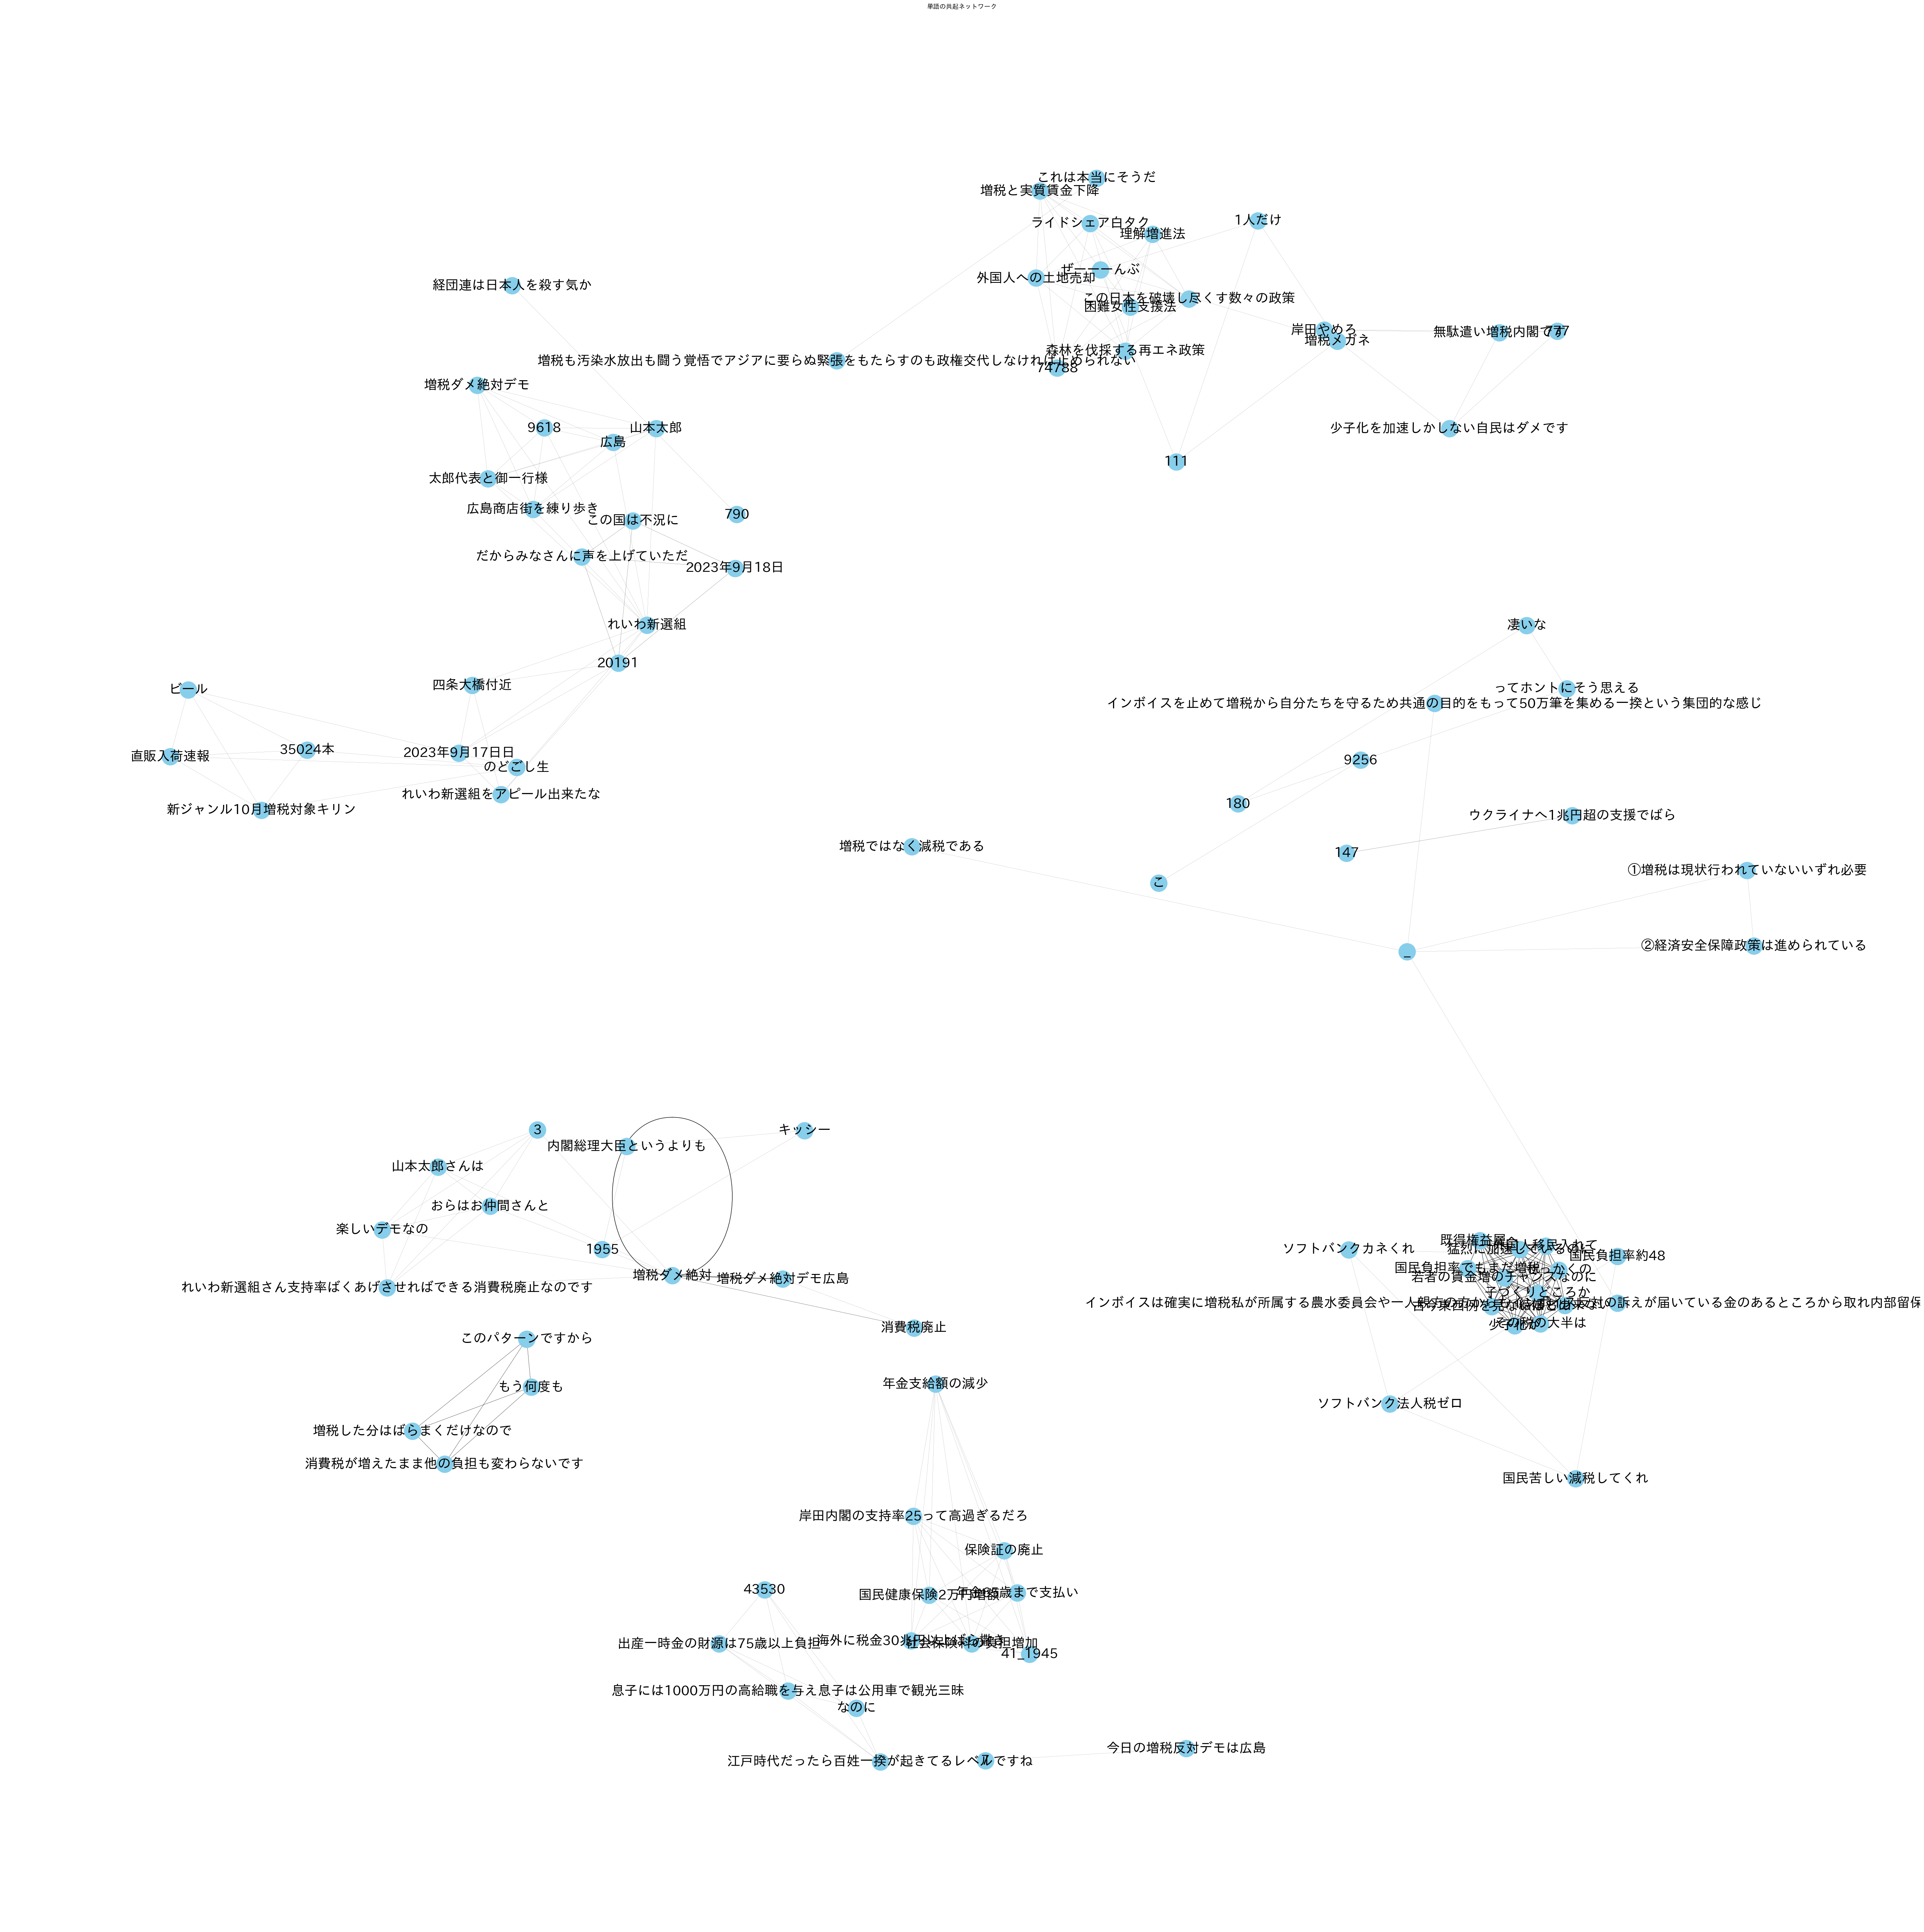

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 50))
pos = nx.spring_layout(G, k=0.4)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, font_size=25, font_weight='bold', font_family = "IPAexGothic",width=[G[u][v]['weight']*0.1 for u,v in G.edges()])
plt.title("単語の共起ネットワーク")
plt.show()
